In [1]:
from collections import namedtuple
from astropy.io.votable import from_table, parse_single_table
from astropy.io import fits
from astropy.table import QTable, Column
from astropy.convolution import convolve
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from RadioAbsTools import cube_tools, spectrum_tools
from astropy.wcs import WCS
import regions
from astropy.coordinates import SkyCoord
import pandas as pd

sns.set()

In [2]:
sns.set(style="darkgrid")
sns.set_context('paper')

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

## Corrected column density
Calculate any stats that depend on the \tau(v) for each spectrum. This includes the corrected column density, equivalent width and the density weighted mean spin temperature. The output of this notebook is a set of figures for these values.

### Table of Contents

* [Define filters](#Define-filters)
* [Corrected Column Density and R_HI](#Corrected-Column-Density-and-R_HI)
* [Comparison to Galactic Surveys](#Comparison-to-Galactic-Surveys)
* [Equivalent Width and the Kanekar, Braun and Roy 2011 Result](#Equivalent-Width-and-the-Kanekar,-Braun-and-Roy-2011-Result)
* [Mean Spin Temperatures](#Mean-Spin-Temperatures)
* [Cool gas fraction](#Cool-gas-fraction)

### Define filters

In [3]:

# Constants

#c0 = 1.823 * 10**18

In [4]:
spectra_table = parse_single_table('gaskap_smc_spectra.vot').to_table()

smc_filter = spectra_table['nh_gass'] >= 2E21

smc_reg = regions.ds9.read.read_ds9('smc-regions-adj2.reg')
bar = smc_reg[0]
wing = smc_reg[1]

header = fits.getheader('SMC_askap_parkes_wsclean_PBC_K.fits')
w = WCS(header)

p = SkyCoord(spectra_table['ra'], spectra_table['dec'], frame='fk5')
is_wing = wing.contains(p, w) & smc_filter
is_bar = bar.contains(p, w) & smc_filter

        Use `regions.Regions.read` instead. [warnings]


In [5]:
smc_hi_table = spectra_table[smc_filter]

smc_noise = spectra_table[smc_filter]['sd_cont']
smc_very_low_noise_filter = smc_noise < 0.04
smc_lower_noise_filt = smc_noise <= 0.1

# Detections including splits by different regions
detections = spectra_table['has_other_abs']

wing_det = is_wing & detections
bar_det = is_bar & detections

non_wing_det = (~is_wing) & detections
other_det = ~(is_wing | is_bar) & detections

non_detect = ~detections & (spectra_table['sd_cont'] < 0.1)

very_low_noise_filter = spectra_table['sd_cont'] < 0.04
low_noise_filter = (spectra_table['sd_cont'] >= 0.04) & (spectra_table['sd_cont'] < 0.1)
mid_noise_filter = (spectra_table['sd_cont'] >= 0.1) & (spectra_table['sd_cont'] < 0.25)
high_noise_filter = (spectra_table['sd_cont'] >= 0.25)

pos_det = detections & (spectra_table['mean_ts'] > 0)



### Corrected Column Density and R_HI

In [6]:
avg_rhi = np.average(spectra_table['r_hi'][smc_filter])
print ("Mean R_HI is {:.3f} for {} SMC sources".format(avg_rhi, np.sum(smc_filter)))



Mean R_HI is 1.137 for 84 SMC sources


In [7]:
from scipy.optimize import curve_fit

# Fitting lines to the different subsets
def test_line(x, a, b):
    return 1 + b * (x - a)

def test_power(x, a, b):
    return a + (x**b)

trimmed_bar_det = bar_det & (spectra_table['nh_uncorr'] > 4e21)
bar_fit, param_cov = curve_fit(test_line, np.log10(spectra_table['nh_uncorr'][trimmed_bar_det]), spectra_table['r_hi'][trimmed_bar_det])
print ("Bar fit = 1 + {:.4f} (log10(NH) - {:.4f})".format(bar_fit[1], bar_fit[0]))

wing_fit, param_cov = curve_fit(test_line, np.log10(spectra_table['nh_uncorr'][wing_det]), spectra_table['r_hi'][wing_det])
print ("Wing fit = 1 + {:.4f} (log10(NH) - {:.4f})".format(wing_fit[1], wing_fit[0]))

wing_fit, param_cov = curve_fit(test_power, np.log10(spectra_table['nh_uncorr'][wing_det]), spectra_table['r_hi'][wing_det])
print ("Wing fit = {:.4f} + log10(NH)^{:.4f}".format(wing_fit[0], wing_fit[1]))

Bar fit = 1 + 0.5099 (log10(NH) - 21.4312)
Wing fit = 1 + 0.7542 (log10(NH) - 21.3534)
Wing fit = -16.3133 + log10(NH)^0.9315


/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/1000101597.py:3: RuntimeWarning: divide by zero encountered in log10
  log_n_h = np.log10(spectra_table['nh_uncorr'])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/1000101597.py:25: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/1000101597.py:25: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])


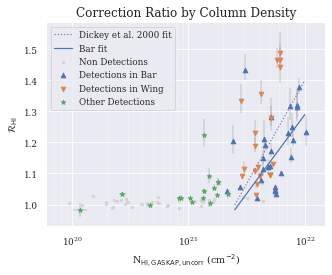

In [8]:

fig, ax = plt.subplots(1,1, figsize=(5,3.75))

log_n_h = np.log10(spectra_table['nh_uncorr'])

ax.scatter(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], marker='.', color='lightgray', label='Non Detections')
#ax.errorbar(spectra_table['nh_uncorr'][non_detect], spectra_table['r_hi'][non_detect], xerr=e_log_n_h[non_detect], fmt=".", color='lightgray')

ax.errorbar(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], 
            xerr=[spectra_table['e_nh_uncorr_low'][bar_det],spectra_table['e_nh_uncorr_high'][bar_det]], 
            yerr=[spectra_table['e_r_hi_low'][bar_det],spectra_table['e_r_hi_high'][bar_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][bar_det], spectra_table['r_hi'][bar_det], marker='^', label='Detections in Bar')

ax.errorbar(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], 
            xerr=[spectra_table['e_nh_uncorr_low'][wing_det],spectra_table['e_nh_uncorr_high'][wing_det]], 
            yerr=[spectra_table['e_r_hi_low'][wing_det],spectra_table['e_r_hi_high'][wing_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][wing_det], spectra_table['r_hi'][wing_det], marker='v', label='Detections in Wing')

ax.errorbar(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], 
            xerr=[spectra_table['e_nh_uncorr_low'][other_det],spectra_table['e_nh_uncorr_high'][other_det]], 
            yerr=[spectra_table['e_r_hi_low'][other_det],spectra_table['e_r_hi_high'][other_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(spectra_table['nh_uncorr'][other_det], spectra_table['r_hi'][other_det], marker='*', label='Other Detections')



ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(6E19, 1.5E22)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\mathcal{R}_{\rm HI}$')
ax.set_title('Correction Ratio by Column Density', size=12)
nh_sample = np.linspace(2.5E21, 1E22,1000)
d00_line = 1+0.667*(np.log10(nh_sample)-21.4)
ax.plot(nh_sample, d00_line, label="Dickey et al. 2000 fit", c="C4", ls=':')
bar_line = 1 + bar_fit[1] * (np.log10(nh_sample) - bar_fit[0])
ax.plot(nh_sample, bar_line, label="Bar fit", c="C0")
#wing_line = wing_fit[0] + wing_fit[1]*(np.log10(nh_sample))
#wing_line = wing_fit[0] + (np.log10(nh_sample))**wing_fit[1]
#ax.plot(nh_sample, wing_line, label="Wing fit", c="C1", ls=':')


plt.grid(True, which="major", ls="-")
plt.grid(True, which="minor", ls=":")

ax.legend(loc='upper left')
fig.savefig('figures/nh_rhi_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_rhi_detections.pdf', bbox_inches='tight')

In [9]:

df = pd.DataFrame(data={'log_nh':np.log10(spectra_table['nh_uncorr'][wing_det | bar_det]), 
                        'r_hi': spectra_table['r_hi'][wing_det | bar_det]})

In [10]:
region = np.full(spectra_table['nh_uncorr'].shape, "Other")
region[wing_det] = "Wing"
region[bar_det] = "Bar"
df['region'] = region[wing_det | bar_det]

Bar: log10(NH) min: 21.33 median: 21.73 max: 22.01
Wing: log10(NH) min: 21.45 median: 21.62 max: 21.78
Bar: R_HI min: 1.02 median: 1.16 max: 1.43
Wing: R_HI min: 1.03 median: 1.13 max: 1.49


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


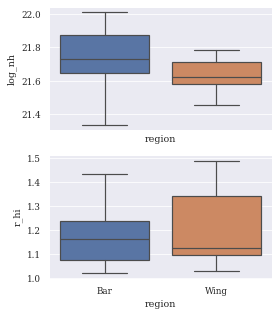

In [11]:
f, axs = plt.subplots(2,1,
                      figsize=(4,5),
                      sharex=True)

ax = sns.boxplot(x="region", y="log_nh", data=df, ax=axs[0])
ax = sns.boxplot(x="region", y="r_hi", data=df, ax=axs[1])

bar_nh = np.log10(spectra_table['nh_uncorr'][bar_det])
print ("Bar: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_nh), np.median(bar_nh), np.max(bar_nh)))
wing_nh = np.log10(spectra_table['nh_uncorr'][wing_det])
print ("Wing: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_nh), np.median(wing_nh), np.max(wing_nh)))

bar_rhi = spectra_table['r_hi'][bar_det]
print ("Bar: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_rhi), np.median(bar_rhi), np.max(bar_rhi)))
wing_rhi = spectra_table['r_hi'][wing_det]
print ("Wing: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_rhi), np.median(wing_rhi), np.max(wing_rhi)))




Bar: log10(NH) min: 21.33 median: 21.73 max: 22.01
Wing: log10(NH) min: 21.45 median: 21.62 max: 21.78
Bar: R_HI min: 1.02 median: 1.16 max: 1.43
Wing: R_HI min: 1.03 median: 1.13 max: 1.49


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


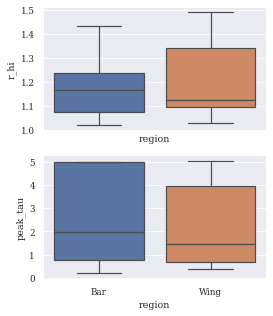

In [12]:
df['peak_tau'] = spectra_table['peak_tau'][wing_det | bar_det]

f, axs = plt.subplots(2,1,
                      figsize=(4,5),
                      sharex=True)

ax = sns.boxplot(x="region", y="r_hi", data=df, ax=axs[0])
ax = sns.boxplot(x="region", y="peak_tau", data=df, ax=axs[1])

bar_nh = np.log10(spectra_table['nh_uncorr'][bar_det])
print ("Bar: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_nh), np.median(bar_nh), np.max(bar_nh)))
wing_nh = np.log10(spectra_table['nh_uncorr'][wing_det])
print ("Wing: log10(NH) min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_nh), np.median(wing_nh), np.max(wing_nh)))

bar_rhi = spectra_table['r_hi'][bar_det]
print ("Bar: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(bar_rhi), np.median(bar_rhi), np.max(bar_rhi)))
wing_rhi = spectra_table['r_hi'][wing_det]
print ("Wing: R_HI min: {:.2f} median: {:.2f} max: {:.2f}".format(np.min(wing_rhi), np.median(wing_rhi), np.max(wing_rhi)))





### Comparison to Galactic Surveys

In [13]:
hdul = fits.open('reference/integrated_properties_comparison.fits') 
comparison_data = hdul[1].data
comparison_data[:2]
sponge = comparison_data['tags']=='SPONGE'
perseus = comparison_data['tags']=='Perseus'
ht03 = comparison_data['tags']=='HT03'

hdul = fits.open('reference/integrated_properties_mach.fits') 
mach_data = hdul[1].data

In [14]:
print (len(comparison_data), np.sum(sponge), np.sum(perseus), np.sum(ht03), len(mach_data))
comparison_data[:2]

103 43 22 38 44


FITS_rec([( 7.67231523, 0.27895691, 6.97869436, 0.24236883, 185.30870236, 0.49059084, 0.25161932, 0.093621  , 1.09939121, 0.05032406,  12.18140738,  37.00643067, 241.18704832,  1.29800611, '3C327.1A', 'SPONGE'),
          (10.55743079, 0.4258176 , 9.55067593, 0.35956501, 191.86620179, 0.30981149, 0.23484189, 0.08802757, 1.1054119 , 0.05532947, 166.63568163, -33.59591844,  49.74084441, 16.47574959, '4C16.09', 'SPONGE')],
         dtype=(numpy.record, [('nhi_iso', '>f8'), ('nhi_iso_err', '>f8'), ('nhi_thin', '>f8'), ('nhi_thin_err', '>f8'), ('intts_abs', '>f8'), ('intts_abs_err', '>f8'), ('fcnm_abs', '>f8'), ('fcnm_abs_err', '>f8'), ('rhi_abs', '>f8'), ('rhi_abs_err', '>f8'), ('l', '>f8'), ('b', '>f8'), ('ra', '>f8'), ('dec', '>f8'), ('names', 'S9'), ('tags', 'S7')]))

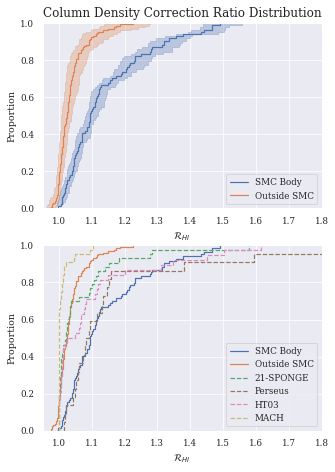

In [15]:
fig, axs = plt.subplots(2,1, figsize=(5,7.5))

rhi_smc = smc_hi_table['r_hi']
rhi_low_smc = smc_hi_table['r_hi'] - smc_hi_table['e_r_hi_low']
rhi_high_smc = smc_hi_table['r_hi'] + smc_hi_table['e_r_hi_high']

#ln_filter = (non_detect | detections) & (spectra_table['r_hi'] > 0) # Includes everything plotted in the Correction Ratio by Column Density plot
has_rhi_filter = spectra_table['r_hi'] > 0
rhi_all = spectra_table['r_hi'][has_rhi_filter]
rhi_low_all = spectra_table['r_hi'][has_rhi_filter] - spectra_table['e_r_hi_low'][has_rhi_filter]
rhi_high_all = spectra_table['r_hi'][has_rhi_filter] + spectra_table['e_r_hi_high'][has_rhi_filter]

field_filter = ~smc_filter & (spectra_table['r_hi'] > 0)
rhi_field = spectra_table['r_hi'][field_filter]
rhi_low_field = spectra_table['r_hi'][field_filter] - spectra_table['e_r_hi_low'][field_filter]
rhi_high_field = spectra_table['r_hi'][field_filter] + spectra_table['e_r_hi_high'][field_filter]



ax = axs[0]
ecdf = sns.ecdfplot(x=rhi_smc, complementary=False, ax=ax, legend=False, color='C0')
num = len(rhi_low_smc)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(rhi_low_smc), np.sort(rhi_high_smc), color='C0', alpha=0.3, step='pre')

ecdf = sns.ecdfplot(x=rhi_field, complementary=False, ax=ax, legend=False, color='C1')
num = len(rhi_low_field)
y = np.arange(num)/float(num)+ 1/float(num)
ax.fill_betweenx(y, np.sort(rhi_low_field), np.sort(rhi_high_field), color='C1', alpha=0.3, step='pre')
ax.set_xlim(0.95,1.8)

ax.set_xlabel(r'$\mathcal{R}_{HI}$')
ax.set_title('Column Density Correction Ratio Distribution', size=12)

ax.legend(['SMC Body', 'Outside SMC'], loc='lower right')






ax = axs[1]

ecdf = sns.ecdfplot(x=rhi_smc, complementary=False, ax=ax, legend=False, color='C0', zorder=2)
ecdf = sns.ecdfplot(x=rhi_field, complementary=False, ax=ax, legend=False, color='C1', zorder=2)
colors = ['C2', 'C5', 'C6']
for idx, label in enumerate(('SPONGE', 'Perseus', 'HT03')):
    comp_filt = comparison_data['tags']==label
    rhi = comparison_data['rhi_abs'][comp_filt].astype('float64')
    sns.ecdfplot(x=rhi, ax=ax, legend=False, ls='--', color=colors[idx])
sns.ecdfplot(x=mach_data['rhi_abs'].astype('float64'), ax=ax, legend=False, ls='--', color='C8')
ax.set_xlim(0.95,1.8)
ax.set_xlabel(r'$\mathcal{R}_{HI}$')

ax.legend(['SMC Body', 'Outside SMC', '21-SPONGE', 'Perseus', 'HT03', 'MACH'])

plt.savefig('figures/r_hi_cdf_smc_comp.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/r_hi_cdf_smc_comp.pdf', bbox_inches='tight')




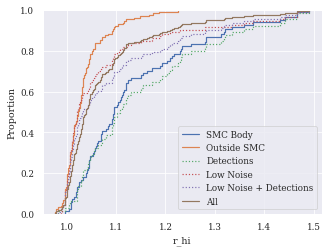

In [16]:
# Test out different subsets of the data for the CDF plots
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
sns.ecdfplot(x=smc_hi_table['r_hi'], complementary=False, ax=ax, legend=False)
sns.ecdfplot(x=spectra_table['r_hi'][~smc_filter], complementary=False, ax=ax, legend=False)
sns.ecdfplot(x=spectra_table['r_hi'][detections], complementary=False, ax=ax, legend=False, ls=':')

ln_filter = (very_low_noise_filter | low_noise_filter)  & (spectra_table['r_hi'] > 0)
sns.ecdfplot(x=spectra_table['r_hi'][ln_filter], complementary=False, ax=ax, legend=False, ls=':')

#ln_filter = very_low_noise_filter | low_noise_filter | detections
#sns.ecdfplot(x=spectra_table['r_hi'][ln_filter], complementary=False, ax=ax, legend=False)

ln_filter = (non_detect | detections)  & (spectra_table['r_hi'] > 0)
sns.ecdfplot(x=spectra_table['r_hi'][ln_filter], complementary=False, ax=ax, legend=False, ls=':')

sns.ecdfplot(x=spectra_table['r_hi'], complementary=False, ax=ax, legend=False)



ax.legend(['SMC Body', 'Outside SMC', 'Detections', 'Low Noise', 'Low Noise + Detections', 'All'])

fig.savefig('figures/rhi_cdf_sampler.pdf', bbox_inches='tight')

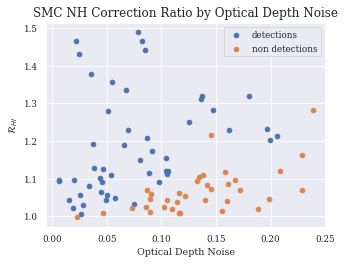

In [17]:
fig, ax = plt.subplots(1,1, figsize=(5,3.75))
rhi = smc_hi_table['r_hi']#[smc_hi_table['has_other_abs']]
sdcont = smc_hi_table['sd_cont']#[smc_hi_table['has_other_abs']]
smc_det = smc_hi_table['has_other_abs']
ax.scatter(sdcont[smc_det], rhi[smc_det], label="detections")
ax.scatter(sdcont[~smc_det], rhi[~smc_det], label="non detections")

ax.set_ylabel(r'$\mathcal{R}_{HI}$')
ax.set_xlabel(r'Optical Depth Noise')
ax.legend()

ax.set_title('SMC NH Correction Ratio by Optical Depth Noise', size=12)

plt.savefig('figures/r_hi_by_noise.png', bbox_inches='tight', dpi=200)

### Equivalent Width and the Kanekar, Braun and Roy 2011 Result

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/59456907.py:27: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/59456907.py:27: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/59456907.py:29: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lg

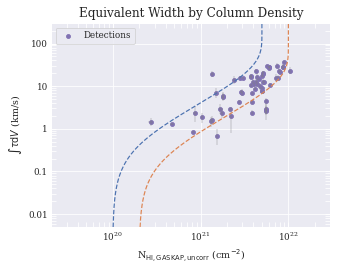

In [18]:
all_nh = spectra_table['nh_uncorr']
all_ew = spectra_table['ew']

tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))


pos_det = detections & (spectra_table['mean_ts'] > 0)


tauvals = np.logspace(np.log10(0.005), np.log10(300), 200)
kbr11_lower = 1e20*np.exp(-1*tauvals/20)+5e21*(1-np.exp(-1*tauvals/20))
kbr11_upper = 2e20*np.exp(-1*tauvals/10)+1e22*(1-np.exp(-1*tauvals/10))

#fig, ax = plt.subplots(1,1, figsize=(12,9))
fig, ax = plt.subplots(1,1, figsize=(5,3.75))

ax.scatter(all_nh[pos_det], all_ew[pos_det], label=r'Detections', c='C4', s=16)#, marker='*')#, s=60)
ax.errorbar(all_nh[pos_det], all_ew[pos_det], xerr=[spectra_table['e_nh_uncorr_low'][pos_det],spectra_table['e_nh_uncorr_high'][pos_det]], 
            yerr=[spectra_table['e_ew_low'][pos_det],spectra_table['e_ew_high'][pos_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)


ax.plot(kbr11_lower, tauvals, ls='--')
ax.plot(kbr11_upper, tauvals, ls='--')

ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(0.005, 300)
ax.set_yticklabels(labels=['', '', '0.01', '0.1', '1', '10', '100'])
ax.set_xlabel(r'N$_{\rm HI,GASKAP,uncorr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\int \tau {\rm d}V$ (km/s)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=5)
ax.set_title('Equivalent Width by Column Density', size=12)

ax.legend()

fig.savefig('figures/nh_ew_kbr11_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_ew_kbr11_detections.pdf', bbox_inches='tight')

### Mean Spin Temperatures

/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/2356250946.py:31: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/2356250946.py:31: MatplotlibDeprecationWarning: The 'subsx' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz6901lgjxpl6tnfzf6w0000gn/T/ipykernel_13503/2356250946.py:33: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
/var/folders/k8/8zkrhz

Note there are 2 spin temperatures below 50 that are not shown!
>> J013134-700042 [noise=0.108] has T_s=-49.183
>> J013701-730415 [noise=0.036] has T_s=-832.885


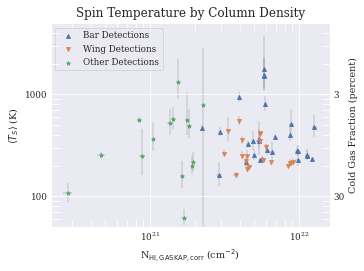

In [19]:
pos_det = detections & (spectra_table['mean_ts'] > 0)
bar_pos_det = bar_det & (spectra_table['mean_ts'] > 0)
wing_pos_det = wing_det & (spectra_table['mean_ts'] > 0)
other_pos_det = other_det & (spectra_table['mean_ts'] > 0)



fig, ax = plt.subplots(1,1, figsize=(5,3.75))

det_mean_ts = spectra_table['mean_ts'][bar_pos_det]
det_nh = spectra_table['nh_corr'][bar_pos_det]
ax.errorbar(det_nh, det_mean_ts, xerr=[spectra_table['e_nh_corr_low'][bar_pos_det],spectra_table['e_nh_corr_high'][bar_pos_det]], 
            yerr=[spectra_table['e_mean_ts_low'][bar_pos_det],spectra_table['e_mean_ts_high'][bar_pos_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(det_nh, det_mean_ts, label=r'Bar Detections', c='C0', s=16, marker='^') 

det_mean_ts = spectra_table['mean_ts'][wing_pos_det]
det_nh = spectra_table['nh_corr'][wing_pos_det]
ax.errorbar(det_nh, det_mean_ts, xerr=[spectra_table['e_nh_corr_low'][wing_pos_det],spectra_table['e_nh_corr_high'][wing_pos_det]], 
            yerr=[spectra_table['e_mean_ts_low'][wing_pos_det],spectra_table['e_mean_ts_high'][wing_pos_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(det_nh, det_mean_ts, label=r'Wing Detections', c='C1', s=16, marker='v') 

det_mean_ts = spectra_table['mean_ts'][other_pos_det]
det_nh = spectra_table['nh_corr'][other_pos_det]
ax.errorbar(det_nh, det_mean_ts, xerr=[spectra_table['e_nh_corr_low'][other_pos_det],spectra_table['e_nh_corr_high'][other_pos_det]], 
            yerr=[spectra_table['e_mean_ts_low'][other_pos_det],spectra_table['e_mean_ts_high'][other_pos_det]], color='grey', fmt='none', zorder=1, elinewidth=0.4)
ax.scatter(det_nh, det_mean_ts, label=r'Other Detections', c='C2', s=16, marker='*')


ts_floor = 50
ts_ceil = 5000
ax.set_xscale("log", basex=10,subsx=[2, 3, 4, 5, 6, 7, 8, 9])
#ax.set_xlim(2e19, 3e22)
ax.set_yscale("log", basey=10,subsy=[2, 3, 4, 5, 6, 7, 8, 9])
ax.set_ylim(ts_floor, ts_ceil)
ax.set_xlabel(r'N$_{\rm HI,GASKAP,corr}$ (cm$^{-2}$)')
ax.set_ylabel(r'$\langle T_S \rangle$ (K)')
ax.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax.set_yticklabels(labels=['', '10', '100', '1000'])
ax.legend(loc='upper left')
ax.set_title('Spin Temperature by Column Density', size=12)

ax1a = ax.twinx()
y_range = ax.get_ylim()
ax1a.set_ylim(y_range)
ax1a.set_yscale("log", nonpositive='clip')
ax1a.tick_params(which='both', direction='in', bottom=True, top=True, left=True, right=True, color='w', length=8)
ax1a.set_yticklabels(['', '', '30', '3'])
ax1a.set_ylabel("Cold Gas Fraction (percent)")


fig.savefig('figures/nh_mean_ts_detections.png', bbox_inches='tight', dpi=200)
fig.savefig('figures/nh_mean_ts_detections.pdf', bbox_inches='tight')


hidden_filter = spectra_table['mean_ts'][detections]<ts_floor
if np.sum(hidden_filter) > 0:    
    print ("Note there are {} spin temperatures below {} that are not shown!".format(np.sum(hidden_filter), ts_floor))
    for source in spectra_table[detections][hidden_filter]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))

        
hidden_filter = spectra_table['mean_ts'][detections]>ts_ceil
if np.sum(hidden_filter) > 0:    
    print ("Note there are {} spin temperatures above {} that are not shown!".format(np.sum(hidden_filter), ts_ceil))
    for source in spectra_table[detections][hidden_filter]:
        print ('>> {} [noise={:.3f}] has T_s={:.3f}'.format(source['comp_name'], source['sd_cont'], source['mean_ts']))



In [20]:
weights = 1/(np.max([spectra_table['e_mean_ts_low'],spectra_table['e_mean_ts_high']], axis=0)**2)
print (weights.shape)

all_det_mean_ts = np.average(spectra_table['mean_ts'][pos_det], weights=weights[pos_det])
e_all_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][pos_det]**2))
e_all_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][pos_det]**2))

print ("all detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(all_det_mean_ts, e_all_det_mean_ts_high, e_all_det_mean_ts_low))

smc_det = pos_det & (spectra_table['nh_uncorr'] >= 2e21)
smc_det_mean_ts = np.average(spectra_table['mean_ts'][smc_det], weights=weights[smc_det])
e_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][smc_det]**2))
e_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][smc_det]**2))

print ("smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(smc_det_mean_ts, e_smc_det_mean_ts_high, e_smc_det_mean_ts_low))

non_smc_det = pos_det & (spectra_table['nh_uncorr'] < 2e21)
non_smc_det_mean_ts = np.average(spectra_table['mean_ts'][non_smc_det], weights=weights[non_smc_det])
e_non_smc_det_mean_ts_low = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_low'][non_smc_det]**2))
e_non_smc_det_mean_ts_high = np.sqrt(1/np.sum(1/spectra_table['e_mean_ts_high'][non_smc_det]**2))

print ("non-smc detections <T_S> = {:.1f} +{:.1f} -{:.1f}".format(non_smc_det_mean_ts, e_non_smc_det_mean_ts_high, e_non_smc_det_mean_ts_low))

med_ts_bar = np.median(spectra_table['mean_ts'][bar_pos_det])
med_nh_bar = np.median(spectra_table['nh_uncorr'][bar_pos_det])
w_mean_ts_bar = np.average(spectra_table['mean_ts'][bar_pos_det], weights=weights[bar_pos_det])

print("Bar median NH={:.2e} <T_S>={:.1f} weight mean <T_S>={:.1f}".format(med_nh_bar, med_ts_bar, w_mean_ts_bar))

med_ts_wing = np.median(spectra_table['mean_ts'][wing_pos_det])
med_nh_wing = np.median(spectra_table['nh_uncorr'][wing_pos_det])
w_mean_ts_wing = np.average(spectra_table['mean_ts'][wing_pos_det], weights=weights[wing_pos_det])
min_ts_wing = np.min(spectra_table['mean_ts'][wing_pos_det])
max_ts_wing = np.max(spectra_table['mean_ts'][wing_pos_det])


print("Wing median NH={:.2e} <T_S>={:.1f} (range {:.1f} - {:.1f}) weight mean <T_S>={:.1f}".format(med_nh_wing, med_ts_wing, min_ts_wing, max_ts_wing, w_mean_ts_wing))





(229,)
all detections <T_S> = 253.6 +2.2 -1.9
smc detections <T_S> = 258.6 +2.3 -2.0
non-smc detections <T_S> = 159.4 +9.8 -7.0
Bar median NH=5.36e+21 <T_S>=334.7 weight mean <T_S>=244.2
Wing median NH=4.17e+21 <T_S>=238.4 (range 161.9 - 547.6) weight mean <T_S>=264.8


/Users/jamesdempsey/opt/anaconda3/envs/python3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Cool gas fraction

f_c = N_c / (N_w + N_c)

n_c ~~ f_c N_unc

<T_s> = T_c / f_c

f_c = T_c / <T_s>

In [21]:
t_cool = 30
fraction_cool = t_cool/spectra_table['mean_ts']

Median mean spin temp SMC field 281.47
Median cold gas fraction SMC field TC=30K 0.11


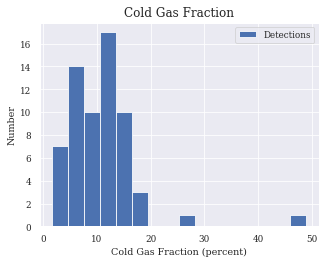

In [22]:
print ("Median mean spin temp SMC field {:.2f}".format(np.median(spectra_table['mean_ts'][pos_det])))

print ("Median cold gas fraction SMC field TC={}K {:.2f}".format(t_cool, np.median(fraction_cool[pos_det])))
det_cool_gas_frac = np.array(fraction_cool[pos_det])*100
det_cool_gas_frac[det_cool_gas_frac>100] = 100
det_cool_gas_frac[det_cool_gas_frac<0] = 0

all_cool_gas_frac = np.array(fraction_cool)*100
all_cool_gas_frac[all_cool_gas_frac>100] = 100
all_cool_gas_frac[all_cool_gas_frac<0] = 0


fig, ax = plt.subplots(1,1, figsize=(5,3.75))

#n, bins, patches = ax.hist(all_cool_gas_frac, bins=16, label='All')
ax.hist(det_cool_gas_frac, bins=16, label='Detections', color='C0')

#ax = sns.histplot(smc_hi_table['r_hi']) #, bins=16)
ax = plt.gca()
ax.set_xlabel(r'Cold Gas Fraction (percent)')
ax.set_ylabel(r'Number')

ax.set_title('Cold Gas Fraction', size=12)

ax.legend()

plt.savefig('figures/fraction_cool_hist_detections.png', bbox_inches='tight', dpi=200)
plt.savefig('figures/fraction_cool_hist_detections.pdf', bbox_inches='tight')
